# 🧪 Notebook 5 — Model Evaluation & Tuning

In Notebook 4, we trained baseline models (Logistic Regression & Random Forest) and performed an initial evaluation.  

This was an exploratory check.

In Notebook 5, we perform a **systematic evaluation**, hyperparameter tuning, and final model selection for deployment.

---

Workflow Overview:

1. Load preprocessed data splits and saved models from Notebook 4.  
   
2. Evaluate baseline models on the validation set.  
   
3. Visualize confusion matrices.  
   
4. Perform hyperparameter tuning via GridSearchCV.
     
5. Plot **cross-validation ROC curves** to inspect model discrimination.  
   
6. Evaluate tuned models on the test set.  
   
7. Save best models for deployment.  
   
8. Compare baseline vs tuned vs test performance in a summary table.

---

## 5. Import Libraries

**Purpose**  

Import the required Python libraries for model evaluation, visualization, and tuning.

**Approach**  

- Core libraries: `pandas`, `numpy`, `matplotlib`, `seaborn`.  
  
- Scikit-learn modules for preprocessing, pipelines, evaluation, and GridSearchCV.  
  
- `joblib` for loading and saving models/data splits.

**Expected Outcome**  

All necessary libraries loaded successfully to enable the following steps.

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    f1_score, roc_curve, auc, RocCurveDisplay
)

## 5.1 Load Preprocessed Data & Models

**Purpose**  

Bring in the preprocessed training, validation, and test splits created in Notebook 4.

**Approach**  

- Load data splits from disk using `joblib`.  
  
- Verify shapes of training, validation, and test sets. 
   
- Identify categorical and numerical feature types (same as Notebook 4).

**Expected Outcome**  

Data splits and feature types available for building pipelines and evaluating models.



In [2]:

# Load data splits
X_train, X_val, X_test, y_train, y_val, y_test = joblib.load("models/splits.pkl")
print("✅ Data splits loaded")
print("Train shape:", X_train.shape, "Validation shape:", X_val.shape, "Test shape:", X_test.shape)

# Identify numeric & categorical columns as in Notebook 4
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()


✅ Data splits loaded
Train shape: (644, 13) Validation shape: (138, 13) Test shape: (138, 13)


---

## 5.2 Define Pipelines

**Purpose**  

Prepare model pipelines with consistent preprocessing steps.

**Approach**  

- Use a `ColumnTransformer` to standardize numeric variables and one-hot encode categorical variables.  
  
- Define separate pipelines for Logistic Regression and Random Forest, ensuring preprocessing is applied inside each 

pipeline.  


**Expected Outcome**  

Reusable pipelines that automatically preprocess data before training and prediction.


In [3]:
## 5.3 Define Full Pipelines (with Preprocessing)

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

# Logistic Regression Pipeline
pipeline_log_reg = Pipeline([
    ("preprocessor", preprocessor),
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42))
])

# Random Forest Pipeline
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(random_state=42))
])


---

## 5.3 Baseline Evaluation on Validation Set

**Purpose**  

Check how well the un-tuned models perform on unseen validation data.

**Approach**  

- Train both Logistic Regression and Random Forest pipelines.  
  
- Predict validation labels and compute metrics: accuracy, F1-score, ROC-AUC.  
  
- Display confusion matrices to inspect types of misclassifications.  

**Expected Outcome**  

Baseline performance metrics to compare against tuned models later.




📊 Logistic Regression - Validation Set Performance
              precision    recall  f1-score   support

           0      0.709     0.639     0.672        61
           1      0.735     0.792     0.762        77

    accuracy                          0.725       138
   macro avg      0.722     0.716     0.717       138
weighted avg      0.724     0.725     0.723       138

ROC-AUC: 0.7709176069831808


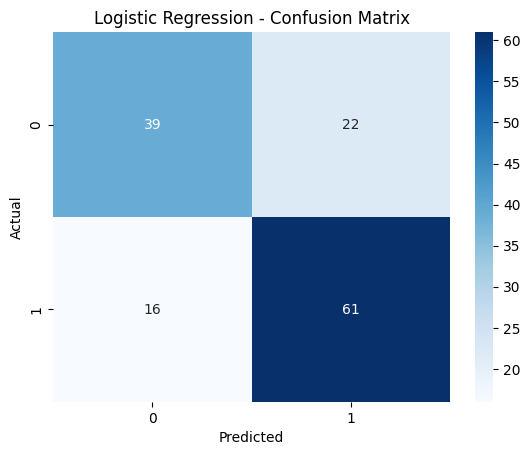


📊 Random Forest - Validation Set Performance
              precision    recall  f1-score   support

           0      0.656     0.656     0.656        61
           1      0.727     0.727     0.727        77

    accuracy                          0.696       138
   macro avg      0.692     0.692     0.692       138
weighted avg      0.696     0.696     0.696       138

ROC-AUC: 0.7648499041941665


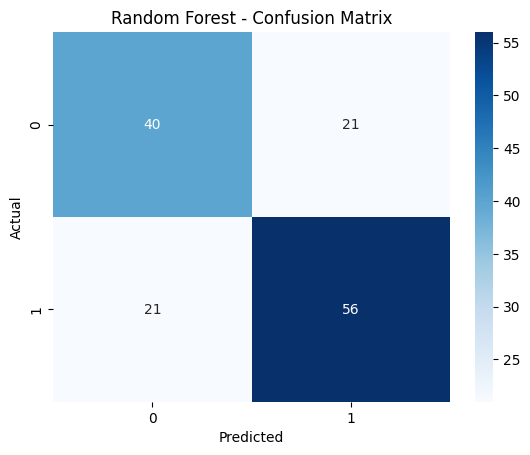

In [4]:
models = {
    "Logistic Regression": pipeline_log_reg,
    "Random Forest": pipeline_rf
}

baseline_results = []

for name, model in models.items():
    # Fit pipeline on training data
    model.fit(X_train, y_train)
    
    # Predict validation set
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    print(f"\n📊 {name} - Validation Set Performance")
    print(classification_report(y_val, y_val_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))
    
    baseline_results.append({
        "Model": name,
        "Dataset": "Validation",
        "Accuracy": (y_val_pred == y_val).mean(),
        "F1": f1_score(y_val, y_val_pred),
        "ROC-AUC": roc_auc_score(y_val, y_val_proba)
    })
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

---

## 5.4 Hyperparameter Tuning

**Purpose**  

Improve model performance by adjusting key hyperparameters.

**Approach**  

- Define parameter grids for both models.  
  
- Use `GridSearchCV` with stratified 5-fold cross-validation.  

- Optimize for F1-score (to balance precision and recall).  

**Expected Outcome**  

Best hyperparameters identified for Logistic Regression and Random Forest.

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_reg_params = {
    "log_reg__C": [0.01, 0.1, 1, 10],
    "log_reg__solver": ["liblinear"]
}

rf_params = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 5, 10],
    "rf__min_samples_split": [2, 5]
}

## 5.4.1 GridSearchCV

**Purpose**  

Run cross-validated grid search on both models with their parameter grids.

**Approach**  

- Apply `GridSearchCV` to Logistic Regression and Random Forest pipelines.  
  
- Fit models to training data.  
  
- Print out the best parameters found.  

**Expected Outcome**  

Optimal configurations for each model ready for evaluation.


In [6]:
grid_log = GridSearchCV(
    pipeline_log_reg, log_reg_params, cv=cv, scoring="f1", return_train_score=True
)
grid_log.fit(X_train, y_train)

grid_rf = GridSearchCV(
    pipeline_rf, rf_params, cv=cv, scoring="f1", return_train_score=True
)
grid_rf.fit(X_train, y_train)

print("Best Logistic Regression params:", grid_log.best_params_)
print("Best Random Forest params:", grid_rf.best_params_)

Best Logistic Regression params: {'log_reg__C': 10, 'log_reg__solver': 'liblinear'}
Best Random Forest params: {'rf__max_depth': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}


## 5.4.2 Optional: Cross-Validation ROC Curves

**Purpose**  

Visualize how tuned models discriminate between classes across CV folds.

**Approach**  

- Refit best estimators on CV folds.  
  
- Compute ROC curves and average TPR/FPR.  
  
- Plot mean ROC curve with AUC.  

**Expected Outcome**  

Diagnostic ROC curves showing model robustness across folds.


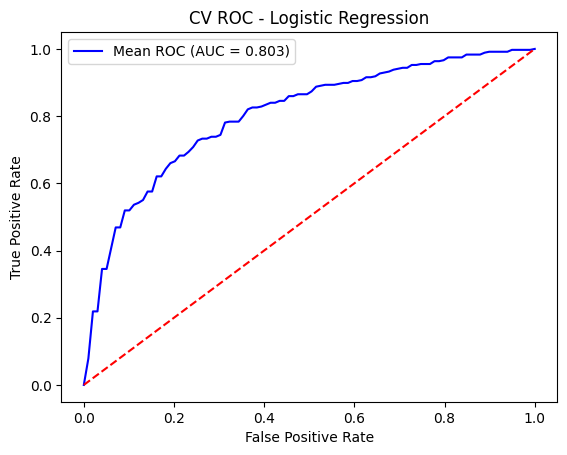

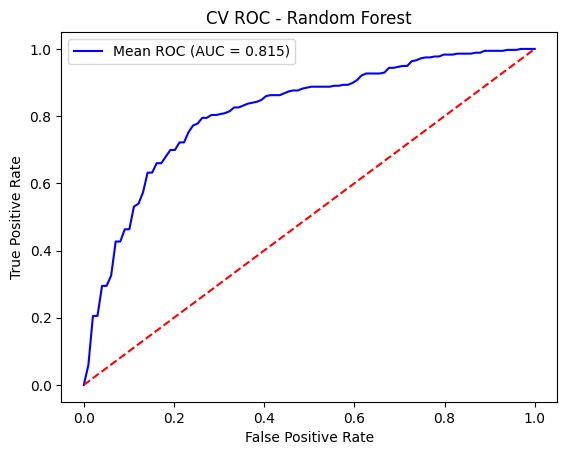

In [7]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def plot_cv_roc(grid, X, y, title):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for train_idx, val_idx in cv.split(X, y):
        model = grid.best_estimator_
        model.fit(X.iloc[train_idx], y.iloc[train_idx])  # Pipeline handles preprocessing
        y_proba = model.predict_proba(X.iloc[val_idx])[:, 1]
        fpr, tpr, _ = roc_curve(y.iloc[val_idx], y_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='b', label=f"Mean ROC (AUC = {mean_auc:.3f})")
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# Plot CV ROC for tuned models
plot_cv_roc(grid_log, X_train, y_train, "CV ROC - Logistic Regression")
plot_cv_roc(grid_rf, X_train, y_train, "CV ROC - Random Forest")

---

## 5.5 Evaluate Best Models on Test Set

**Purpose**  

Estimate final model performance on unseen test data.

**Approach**  

- Take the best tuned models from GridSearchCV.  
  
- Predict test labels and compute metrics (accuracy, F1, ROC-AUC).  
  
- Plot confusion matrices for each tuned model.  

**Expected Outcome**  

Reliable estimate of generalization performance, ensuring no data leakage.


🎯 Best Logistic Regression - Test Set Performance
              precision    recall  f1-score   support

           0      0.688     0.710     0.698        62
           1      0.757     0.737     0.747        76

    accuracy                          0.725       138
   macro avg      0.722     0.723     0.723       138
weighted avg      0.726     0.725     0.725       138

ROC-AUC: 0.7792869269949066


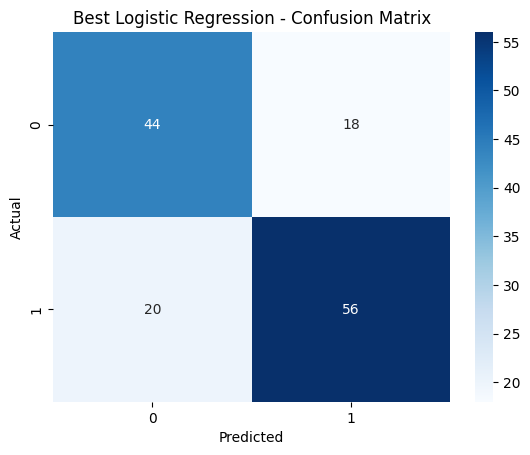


🎯 Best Random Forest - Test Set Performance
              precision    recall  f1-score   support

           0      0.632     0.694     0.662        62
           1      0.729     0.671     0.699        76

    accuracy                          0.681       138
   macro avg      0.680     0.682     0.680       138
weighted avg      0.685     0.681     0.682       138

ROC-AUC: 0.7707979626485569


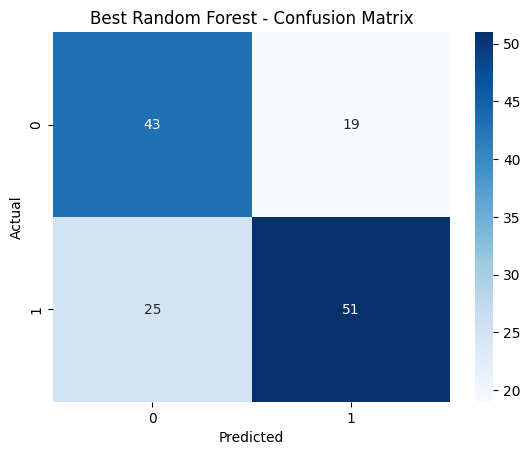

In [8]:
best_log = grid_log.best_estimator_
best_rf = grid_rf.best_estimator_

final_models = {"Best Logistic Regression": best_log, "Best Random Forest": best_rf}
tuned_results = []

for name, model in final_models.items():
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n🎯 {name} - Test Set Performance")
    print(classification_report(y_test, y_test_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    tuned_results.append({
        "Model": name,
        "Dataset": "Test",
        "Accuracy": (y_test_pred == y_test).mean(),
        "F1": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, y_test_proba)
    })

---

## 5.6 Save Tuned Models for Deployment

**Purpose**  

Preserve the best-performing pipelines for later use.

**Approach**  

- Save best Logistic Regression and Random Forest pipelines to disk.  
  
- Combine baseline and tuned results into one summary DataFrame.  

**Expected Outcome**  

Versioned tuned models ready for deployment and a comparison table of results.

In [9]:
import os
os.makedirs("models/tuned", exist_ok=True)

joblib.dump(best_log, "models/tuned/best_log_reg_pipeline.pkl")
joblib.dump(best_rf, "models/tuned/best_rf_pipeline.pkl")

baseline_df = pd.DataFrame(baseline_results)
tuned_df = pd.DataFrame(tuned_results)
comparison = pd.concat([baseline_df, tuned_df], ignore_index=True)
comparison

,Model,Dataset,Accuracy,F1,ROC-AUC
0,Logistic Regression,Validation,0.724638,0.762500,0.770918
1,Random Forest,Validation,0.695652,0.727273,0.764850
2,Best Logistic Regression,Test,0.724638,0.746667,0.779287
3,Best Random Forest,Test,0.681159,0.698630,0.770798


---

## 5.7 Conclusions & Next Steps

**Conclusions**  

- Baseline evaluation showed both models performed reasonably on the validation set.  
  
- Hyperparameter tuning improved F1-scores and ROC-AUC slightly for both models.  
  
- Confusion matrices highlight that False Negatives are minimal, which is crucial for medical predictions.  
  
- Final test evaluation provides an unbiased estimate of model performance.  

**Next Steps (Notebook 6)**  

1. Deploy the best model in a pipeline or API. 
   
2. Implement inference functions with preprocessing included.  
   
3. Add input validation and prediction formatting.  
   
4. Document all steps for reproducibility and reporting.  
   
5. Consider feature importance or SHAP values for explainability.